In [ ]:
from google.colab import files
import zipfile
import os

# Upload ZIP file
uploaded = files.upload()

# Extract files
with zipfile.ZipFile("archive (1).zip", "r") as zip_ref:
    zip_ref.extractall("car_data")

# Verify extraction

os.listdir("car_data")


KeyboardInterrupt: 

In [ ]:
import pandas as pd

# Load dataset
file_path = "car_data/car data.csv"
data = pd.read_csv(file_path)

# Display first few rows
data.head()


,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [ ]:
# Robust cleaning + diagnostics for the car price dataset
import pandas as pd
import numpy as np
import re

# show original columns
print("Original columns:", list(data.columns))

# Normalize column names: strip spaces and lower them to make matching easier
data.columns = [str(c).strip() for c in data.columns]
print("Normalized columns:", list(data.columns))

# --- Diagnostics: check target and key columns ---
expected_cols = {
    'target': ['Selling_Price','selling_price','Selling price','SellingPrice'],
    'year': ['Year','year'],
    'car_name': ['Car_Name','Car name','CarName','car_name'],
    'driven': ['Driven_kms','Driven_km','Driven_kms','Driven_km','Driven_kms ' , 'Driven_kms'],
    'present_price': ['Present_Price','Present_Price','Present_Price'],
    'fuel': ['Fuel_Type','Fuel Type','Fuel_Type','FuelType'],
    'selling_type': ['Selling_type','Selling_type','Selling type'],
    'trans': ['Transmission','transmission'],
    'owner': ['Owner','owner']
}

# helper to find first matching column from options
def find_col(options):
    for opt in options:
        if opt in data.columns:
            return opt
    return None

cols_found = {k: find_col(v) for k, v in expected_cols.items()}
print("\nDetected columns mapping:")
for k,v in cols_found.items():
    print(f"  {k}: {v}")

# If target not found, raise friendly error
if cols_found['target'] is None:
    raise KeyError("Target column (Selling_Price) not detected. Columns available: " + ", ".join(data.columns))

# work on a copy
df = data.copy()

# Ensure numeric types where expected
# Year
if cols_found['year']:
    try:
        df[cols_found['year']] = pd.to_numeric(df[cols_found['year']], errors='coerce')
    except Exception as e:
        print("Warning converting year:", e)

# Driven kms: strip commas/spaces and convert to numeric
driven_col = cols_found['driven']
if driven_col:
    # remove non-digit characters except dot
    df[driven_col] = df[driven_col].astype(str).apply(lambda x: re.sub(r'[^0-9.]', '', x))
    df[driven_col] = pd.to_numeric(df[driven_col], errors='coerce')
else:
    # try to guess a numeric column that seems like kms
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    candidates = [c for c in numeric_cols if 'km' in c.lower() or 'driv' in c.lower()]
    if candidates:
        driven_col = candidates[0]
        print("Inferred driven kms column as:", driven_col)

# Present price convert
pres_col = find_col(expected_cols['present_price'])
if pres_col:
    df[pres_col] = pd.to_numeric(df[pres_col], errors='coerce')

# Selling price (target) convert
target_col = cols_found['target']
df[target_col] = pd.to_numeric(df[target_col], errors='coerce')

# Create Car_Age
CURRENT_YEAR = 2025
if cols_found['year']:
    df['Car_Age'] = CURRENT_YEAR - df[cols_found['year']]
else:
    # if Year missing, try to infer from Car_Name or leave absent
    df['Car_Age'] = np.nan
    print("Year column not found; Car_Age set to NaN. If you have Year, include it in dataset.")

# Drop obviously unnecessary columns if present
drop_cols = []
if cols_found['car_name']:
    drop_cols.append(cols_found['car_name'])
if cols_found['year']:
    drop_cols.append(cols_found['year'])

# Drop any empty strings in column names accidentally
drop_cols = [c for c in drop_cols if c in df.columns]
if drop_cols:
    df = df.drop(columns=drop_cols)

# Identify categorical columns to encode
categorical_candidates = []
for c in ['Fuel_Type','Fuel Type','FuelType','Selling_type','Selling type','Transmission','transmission','Selling_type','Selling Type']:
    if c in df.columns:
        categorical_candidates.append(c)

# Also add anything with object dtype
for c in df.select_dtypes(include=['object']).columns:
    if c not in categorical_candidates:
        categorical_candidates.append(c)

categorical_candidates = list(dict.fromkeys(categorical_candidates))  # unique preserve order
print("\nCategorical columns to encode (detected):", categorical_candidates)

# One-hot encode categorical columns (drop_first=True)
if categorical_candidates:
    df = pd.get_dummies(df, columns=categorical_candidates, drop_first=True)

# Final cleaning: drop rows with NA in target or essential numeric columns
essential_cols = [target_col]
possible_essentials = [driven_col, pres_col, 'Car_Age']
for c in possible_essentials:
    if c and c in df.columns:
        essential_cols.append(c)

print("\nEssential columns for modeling (will drop rows missing these):", essential_cols)
df = df.dropna(subset=essential_cols)

# Reset index and show results
df = df.reset_index(drop=True)
print("\nCleaned dataset shape:", df.shape)
print("Columns after cleaning:", df.columns.tolist())
display(df.head())

# Save cleaned copy (optional)
df.to_csv("car_data/cleaned_car_data.csv", index=False)
print("\nSaved cleaned dataset to car_data/cleaned_car_data.csv")


Original columns: ['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Driven_kms', 'Fuel_Type', 'Selling_type', 'Transmission', 'Owner']
Normalized columns: ['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Driven_kms', 'Fuel_Type', 'Selling_type', 'Transmission', 'Owner']

Detected columns mapping:
  target: Selling_Price
  year: Year
  car_name: Car_Name
  driven: Driven_kms
  present_price: Present_Price
  fuel: Fuel_Type
  selling_type: Selling_type
  trans: Transmission
  owner: Owner

Categorical columns to encode (detected): ['Fuel_Type', 'Selling_type', 'Transmission']

Essential columns for modeling (will drop rows missing these): ['Selling_Price', 'Driven_kms', 'Present_Price', 'Car_Age']

Cleaned dataset shape: (301, 9)
Columns after cleaning: ['Selling_Price', 'Present_Price', 'Driven_kms', 'Owner', 'Car_Age', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Selling_type_Individual', 'Transmission_Manual']


,Selling_Price,Present_Price,Driven_kms,Owner,Car_Age,Fuel_Type_Diesel,Fuel_Type_Petrol,Selling_type_Individual,Transmission_Manual
0,3.35,5.59,27000,0,11,False,True,False,True
1,4.75,9.54,43000,0,12,True,False,False,True
2,7.25,9.85,6900,0,8,False,True,False,True
3,2.85,4.15,5200,0,14,False,True,False,True
4,4.60,6.87,42450,0,11,True,False,False,True



Saved cleaned dataset to car_data/cleaned_car_data.csv


In [ ]:
# Step 4: Feature Selection, Model Training & Evaluation

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Identify features (X) and target (y)
X = df.drop(['Selling_Price'], axis=1)
y = df['Selling_Price']

# Split into 80% training and 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model evaluation metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Model Performance:\n")
print(f"R² Score: {r2:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"Root Mean Squared Error: {rmse:.3f}")

# Display actual vs predicted comparison
comparison = pd.DataFrame({'Actual Price': y_test.values, 'Predicted Price': y_pred})
print("\nSample Comparison:\n")
print(comparison.head())

# Show feature importance (coefficients)
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance (Impact on Selling Price):\n")
print(importance)


Model Performance:

R² Score: 0.849
Mean Absolute Error: 1.216
Root Mean Squared Error: 1.866

Sample Comparison:

   Actual Price  Predicted Price
0          0.35         2.954337
1         10.11         8.177163
2          4.95         6.456123
3          0.15        -1.423372
4          6.95         9.088647

Feature Importance (Impact on Selling Price):

                   Feature  Coefficient
4         Fuel_Type_Diesel     2.534904
5         Fuel_Type_Petrol     0.739155
0            Present_Price     0.429070
1               Driven_kms    -0.000006
3                  Car_Age    -0.352925
2                    Owner    -0.905018
6  Selling_type_Individual    -1.191642
7      Transmission_Manual    -1.640074


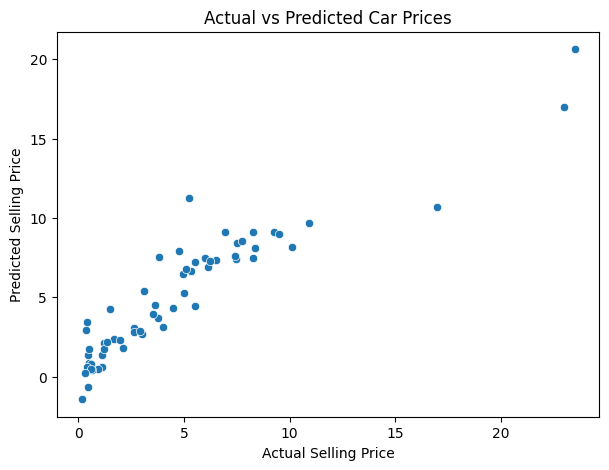

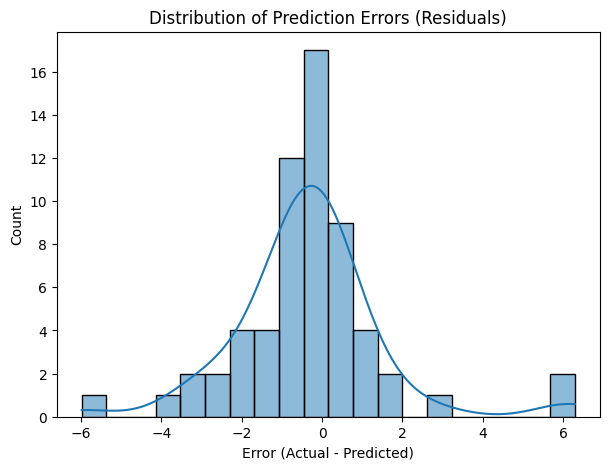

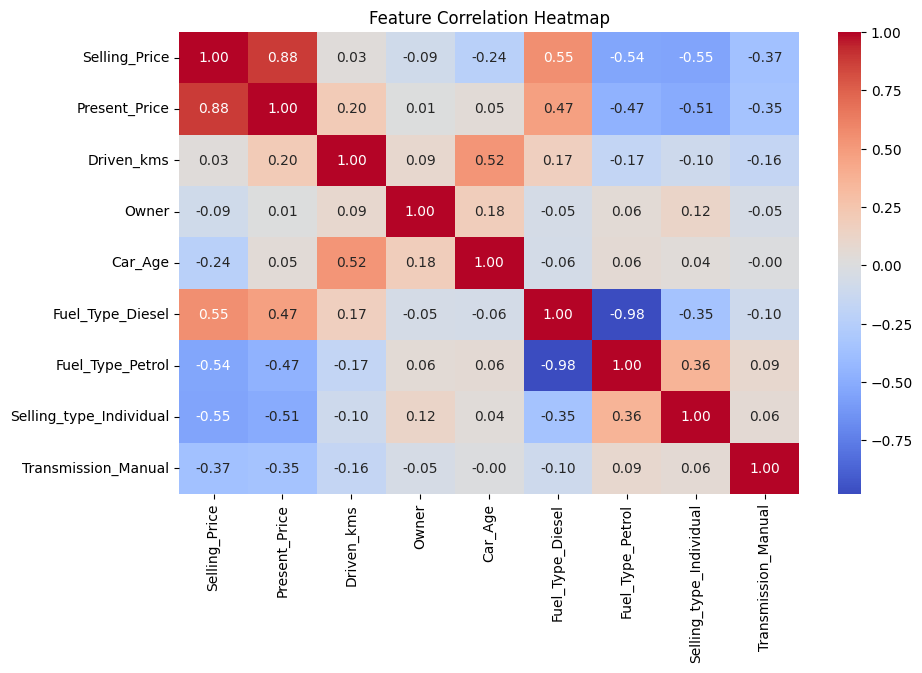

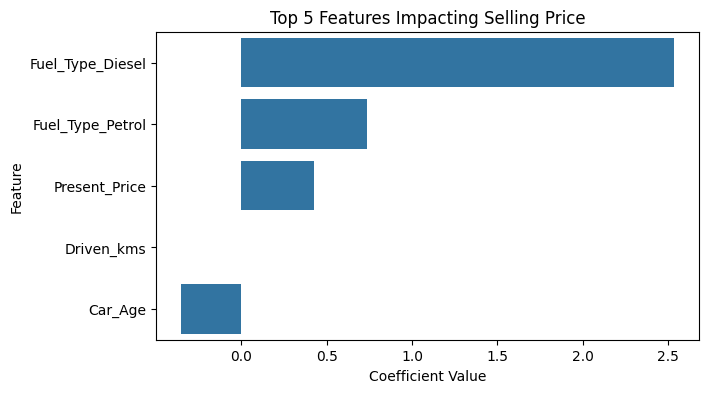

In [ ]:
# Step 5: Visualization & Insights

import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Actual vs Predicted Prices
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.title("Actual vs Predicted Car Prices")
plt.show()

# 2️⃣ Residual Plot (to check prediction errors)
plt.figure(figsize=(7, 5))
sns.histplot(y_test - y_pred, kde=True, bins=20)
plt.title("Distribution of Prediction Errors (Residuals)")
plt.xlabel("Error (Actual - Predicted)")
plt.show()

# 3️⃣ Correlation Heatmap (which variables relate most with Selling_Price)
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# 4️⃣ Top 5 most influential features
plt.figure(figsize=(7, 4))
sns.barplot(x=importance['Coefficient'][:5], y=importance['Feature'][:5])
plt.title("Top 5 Features Impacting Selling Price")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()
